In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pastas as ps

# stel de logger in om alleen foutmeldingen naar het scherm te printen
ps.set_log_level("ERROR")

# print de versies van belangrijke Python packages voor pastas
# ps.show_versions(numba=True)

%config InlineBackend.figure_format = 'retina'

# Voorbewerking
Voor tijdreeksanalyse zijn grondwaterstanden en verklarende reeksen nodig. Beide komen in verschillende lengtes, frequenties en kwaliteit. In veel gevallen is een voorbewerking van de reeksen nodig. In dit notebook wordt geïllustreerd welke bewerkingen je kan doen en wanneer deze nodig zijn.  Onderstaande voorbeelden worden uitgewerkt: 



**Inhoudsopgave**


- [Opschonen stijghoogte reeks](#Opschonen-stijghoogte-reeks)
- [Vereenvoudigen stijghoogte reeks](#Vereenvoudigen-stijghoogte-reeks)
- [Equidistant maken verklarende reeks](#Equidistant-maken-verklarende-reeks)
- [Voorgeschiedenis verklarende reeks](#Voorgeschiedenis-verklarende-reeks)
- [Eenheden afstemmen](#Eenheden-afstemmen)



## Opschonen stijghoogte reeks
Het doel van tijdreeksanalyse is een grondwaterstands of stijghoogte reeks te verklaren uit invoerreeksen. Door middel van automatische optimalisatie probeert de software de reeks zo dicht mogelijk te benaderen. Wanneer er fouten in de reeks aanwezig zijn kan dat grote gevolgen hebben voor de kwaliteit van het model. 
Onderstaand voorbeeld geeft een model dat is geoptimaliseerd zonder een duidelijke uitbijter te verwijderen. 

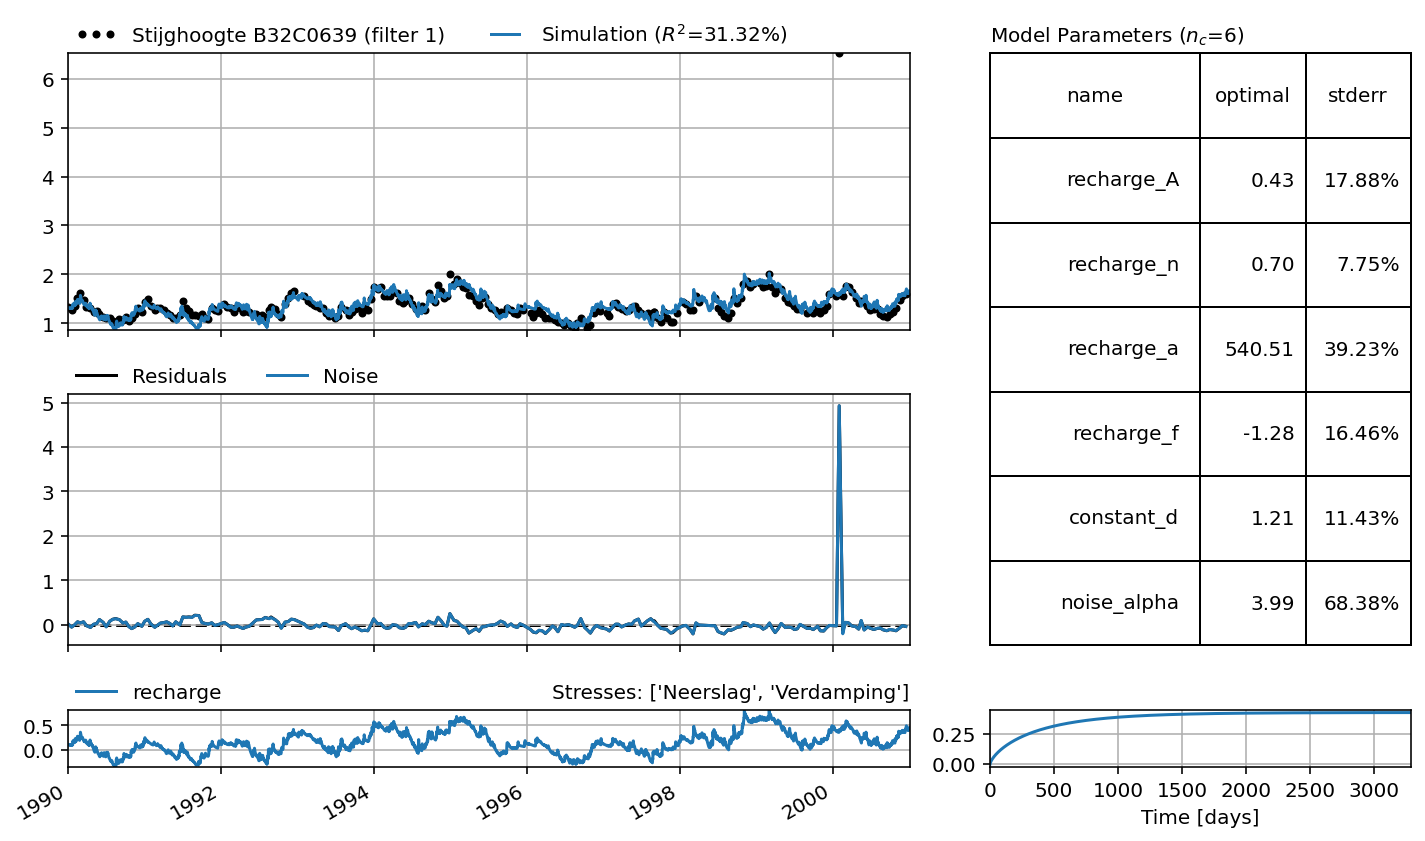

In [2]:
# Read data
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
rain = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series * 1e3
rain.name = "Neerslag"
evap.name = "Verdamping"
head = pd.read_csv("data/B32C0639001_changed.csv",
                   parse_dates=['date'], index_col='date', squeeze=True)
head.name = "Stijghoogte B32C0639 (filter 1)"

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(rm)

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

De resultaten van dit model zijn niet erg bemoedigend. De verklaarde variantie bedraagt slechts 31%. Dit komt mede door de grote afwijking bij de uitbijter,  maar ook de standaard-fouten van de parameters zijn relatief groot en de responstijd van de neerslag en verdamping lijkt voor nederlandse begrippen aan de hoge kant.   
We gaan nu kijken wat de resultaten worden als we de uitbijter verwijderen. 

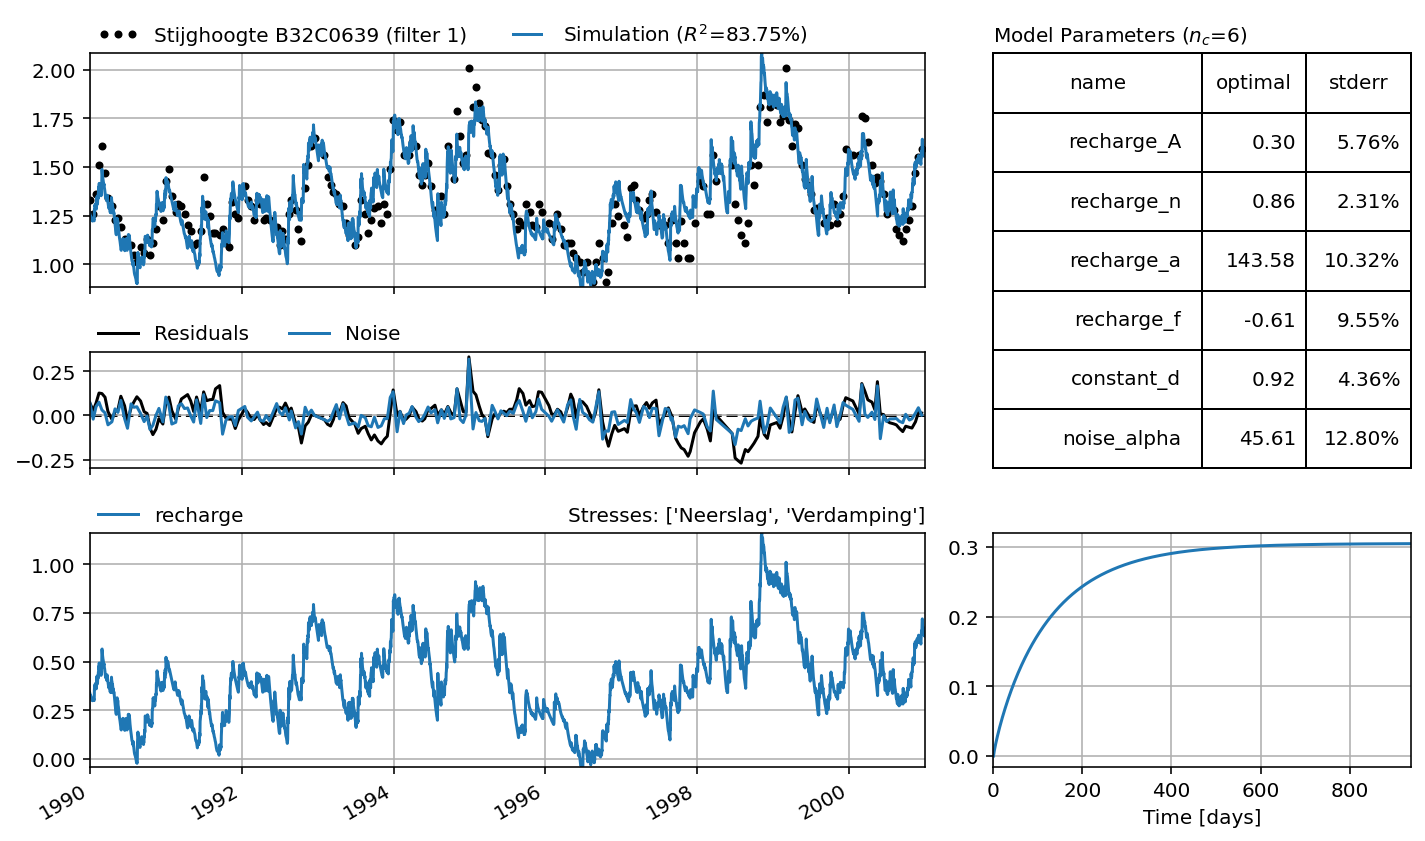

In [3]:
# remove outlier
head.loc[head > 4] = np.nan

# Create the basic Pastas model
ml = ps.Model(head, name="lineair")

# Add a recharge model
rch = ps.rch.Linear()
rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma, name="recharge")
ml.add_stressmodel(rm)

# Solve the model
tmin = "1990"
tmax = "2001"

ml.solve(noise=True, tmin=tmin, tmax=tmax, report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

In bovenstaande figuur is te zien dat het model veel beter presteert met de opgeschoonde reeks. Het blijkt dat de uitbijter (ook als is het er maar één) een grote invloed heeft op het resultaat. Naast een betere fit (84%), zijn ook de standaardfouten kleiner en is de respons korter geworden.     

## Vereenvoudigen stijghoogte reeks
Sommige reeksen bevatten zeer hoogfrequente data, met bijvoorbeeld een tijdstap van een dag of nog korter. Afhankelijk van het doel van de tijdreeksanalyse en de beschikbare invoer, kan het gewenst zijn om de reeksen te aggregeren of uit te dunnen. Het eerste voorbeeld betreft een veelvoorkomende situatie: er is gedurende lange tijd ongeveer tweewekelijks gemeten en sinds enkele jaren op een hoge frequentie. Wanneer we alle metingen gebruiken is het mogelijk dat de nadruk bij de optimalisatie komt te liggen op de periode waar hoogfrequent is gemeten, simpelweg omdat er meer metingen zijn. In het onderstaande voorbeeld is dat het geval. 


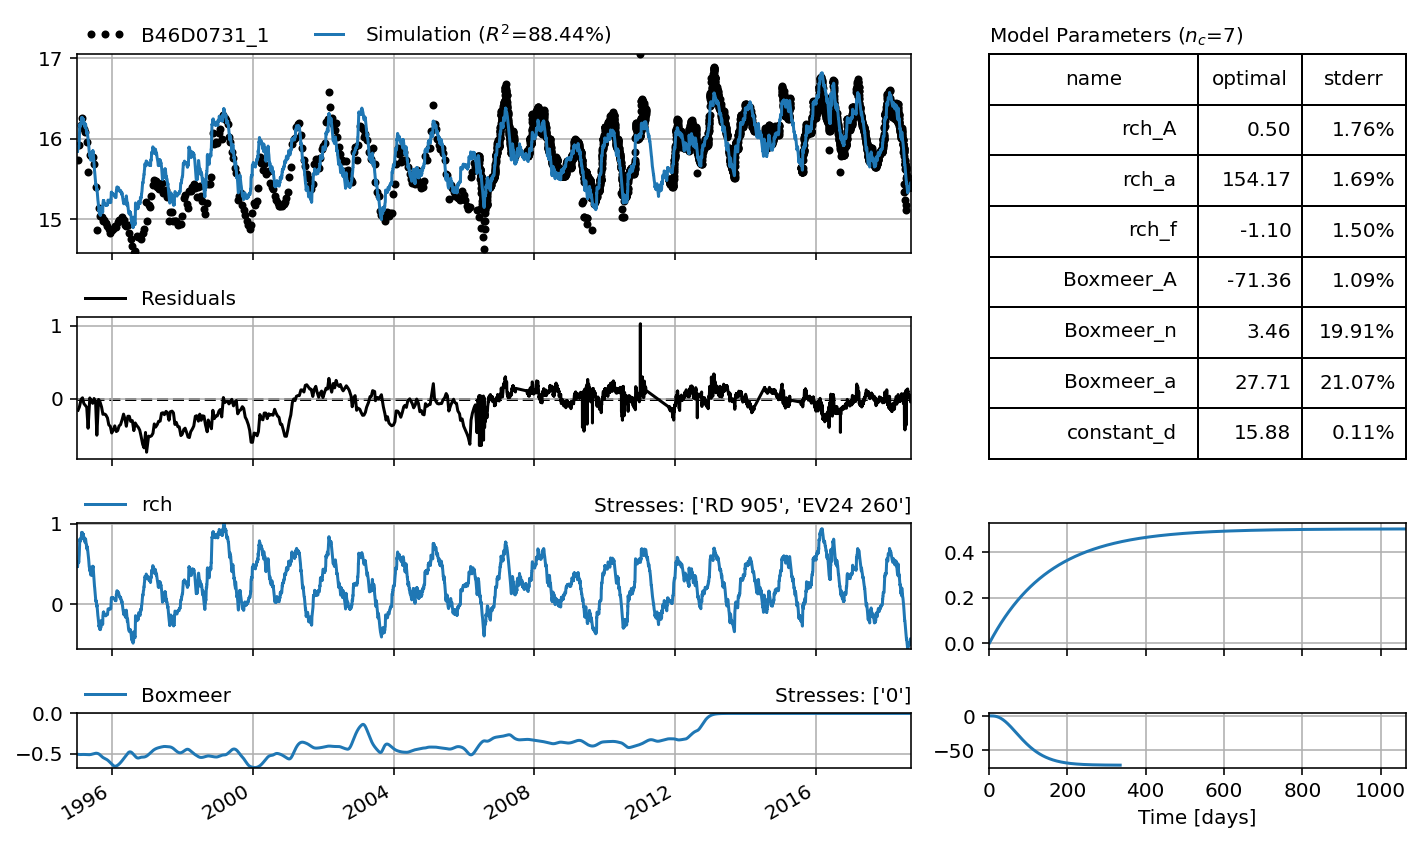

In [4]:
# voorbeeld waar tweewekelijks beter is dan daily
prec = ps.read_knmi("data/precipitation_st_anthonis.txt",
                    variables="RD").series * 1e3
prec = prec.asfreq("D").fillna(0.0)
evap = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series * 1e3
evap = evap.asfreq("D").fillna(0.0)
head = ps.read_dino("data/B46D0731001_1.csv")
gwa_vb = pd.read_csv("data/abstraction_vierlingsbeek_daily.csv",
                     index_col=0, parse_dates=True, squeeze=True)

ml = ps.Model(head, name="B46D0731 (Filter 1)")
sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential, name="rch")
sm2 = ps.StressModel(gwa_vb / 1e6, rfunc=ps.Gamma,
                     name="Boxmeer", up=False, settings="well")
ml.add_stressmodel([sm1, sm2])
#ml.set_parameter("rch_kv", vary=True)
ml.solve(tmin="1995", noise=False, freq='D', report=False)
ml.plots.results(adjust_height=True, figsize=(10, 6));

Vooral in en begin van de reeks zijn de gesimuleerde waarden structureel hoger dan de metingen, terwijl in de tweede helft van de reeks de simulatie gemiddeld beter klopt. Het onderstaande voorbeeld gaat uit van dezelfde invoer, alleen is nu de stijghoogtereeks geresampled zodat er gedurende de hele periode tweewekelijks metingen zijn. 

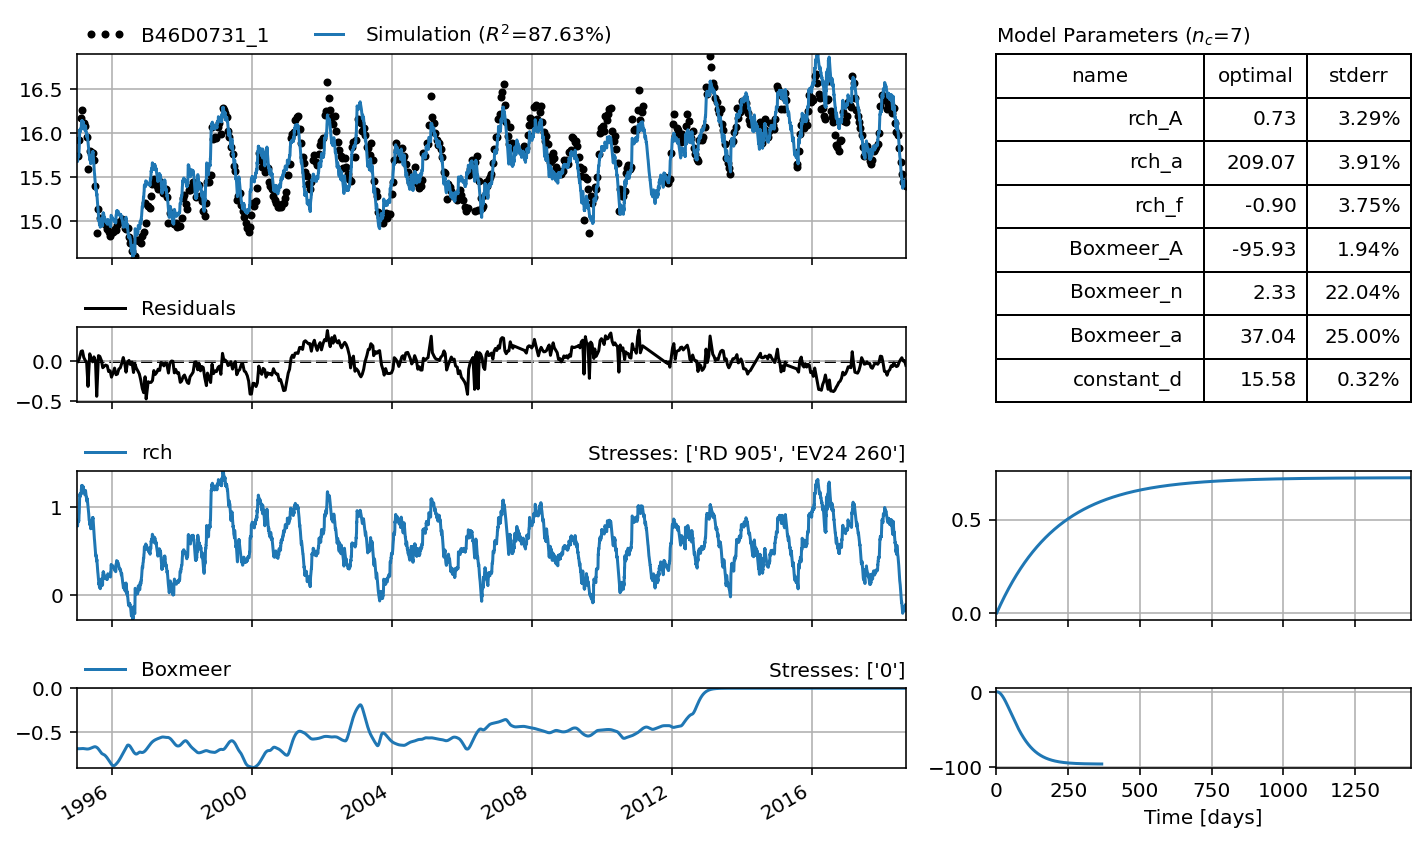

In [5]:
headseries = head.series
index = ps.utils.get_sample(headseries.index, headseries.asfreq('14d').index)
head14D = headseries[index]

ml14D = ps.Model(head14D, name="B46D0731 (Filter 1)")
sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential, name="rch")
sm2 = ps.StressModel(gwa_vb / 1e6, rfunc=ps.Gamma,
                     name="Boxmeer", up=False, settings="well")
ml14D.add_stressmodel([sm1, sm2])
ml14D.solve(tmin="1995", noise=False, freq='D', report=False)
ml14D.plots.results(figsize=(10, 6));

Na het filteren van de hoogfrequente data is te zien dat de residuen nu evenwichter zijn verdeeld over de reeks. De fit in de beginperiode is beter geworden ten koste van de fit aan het eind. Dit heeft ook geleid tot een ander model; ook de responsen van de bijdragen zijn gewijzigd. 
Er zijn ook situaties waarin het juist belangrijk is om een hoge frequentie te handhaven. In het volgende voorbeeld wordt dit geïllustreerd. Het gaat om een peilfilter dat onder invloed staat van het getij. In onderstaande figuur is goed te zien dat de stijghoogte wordt beïnvloed door het getij. 

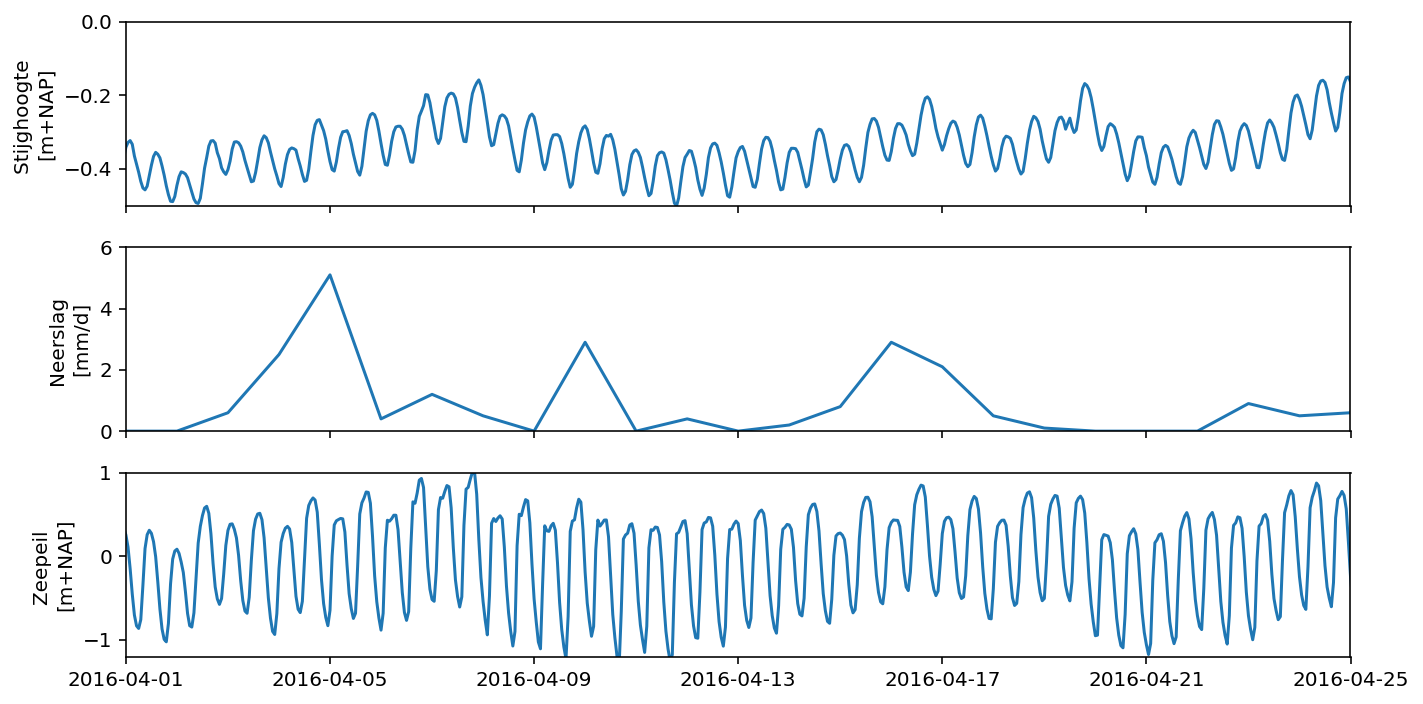

In [6]:
# voorbeeld waar hourly beter is dan daily
head = pd.read_csv("data/PB_1_001_04P001442_F-2224.csv", index_col=0,
                   parse_dates=True, squeeze=True).resample("H").mean().dropna()
prec = pd.read_csv("data/RD Petten.csv", index_col=0, parse_dates=True)
evap = pd.read_csv("data/EV24 De Kooy.csv", index_col=0, parse_dates=True)
sea = pd.read_csv("data/Den Helder.csv", index_col=0, parse_dates=True)

# plaatje met getij
fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
ax1.plot(head)
ax1.set_ylabel('Stijghoogte \n[m+NAP]')
ax2.plot(prec*1000)
ax2.set_ylabel('Neerslag \n[mm/d]')
ax3.plot(sea)
ax3.set_ylabel('Zeepeil \n[m+NAP]')
plt.xlim([np.datetime64("2016-04-01"), np.datetime64("2016-04-25")])
ax1.set_ylim([-0.5, 0])
ax2.set_ylim([0, 6])
ax3.set_ylim([-1.2, 1])
plt.tight_layout()

Als eerste poging maken we een model met een tijdsinterval van een dag. Onderstaande figuur toont het resultaat: 

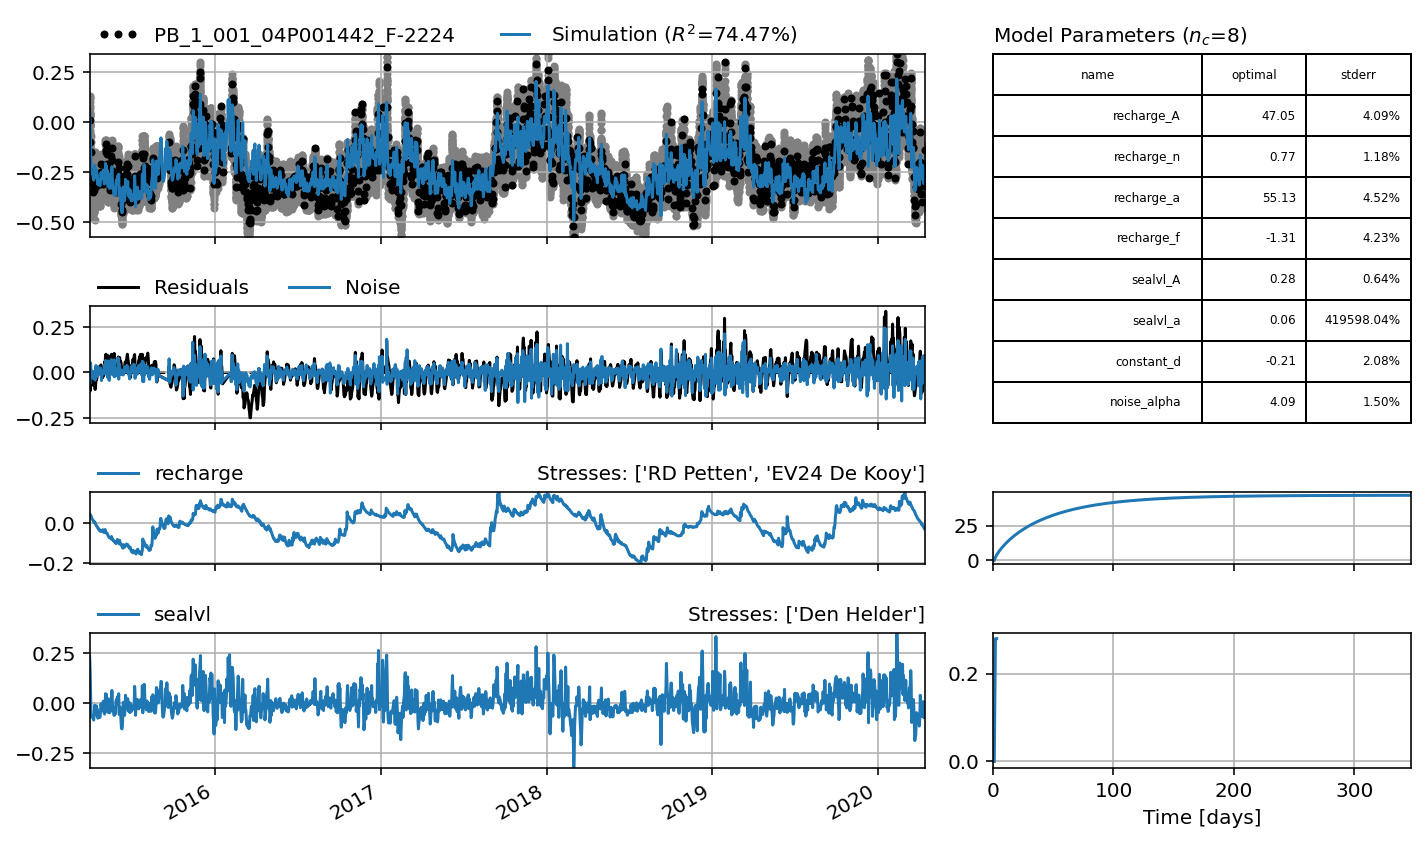

In [7]:
# dagelijks model gaat niet zo goed
ml = ps.Model(head, name="daily")
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma)
ml.add_stressmodel(rm)
sm = ps.StressModel(sea - sea.mean(), ps.Exponential, "sealvl",
                    settings="waterlevel")
ml.add_stressmodel(sm)
ml.solve(noise=True, tmin="2015-04-01", report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout();

Het is duidelijk te zien dat de dagelijkse fluctuatie niet wordt meegenomen.  Er is ook een duidelijk patroon in de residuen te zien. We proberen nu een simulatie op uurwaarde.

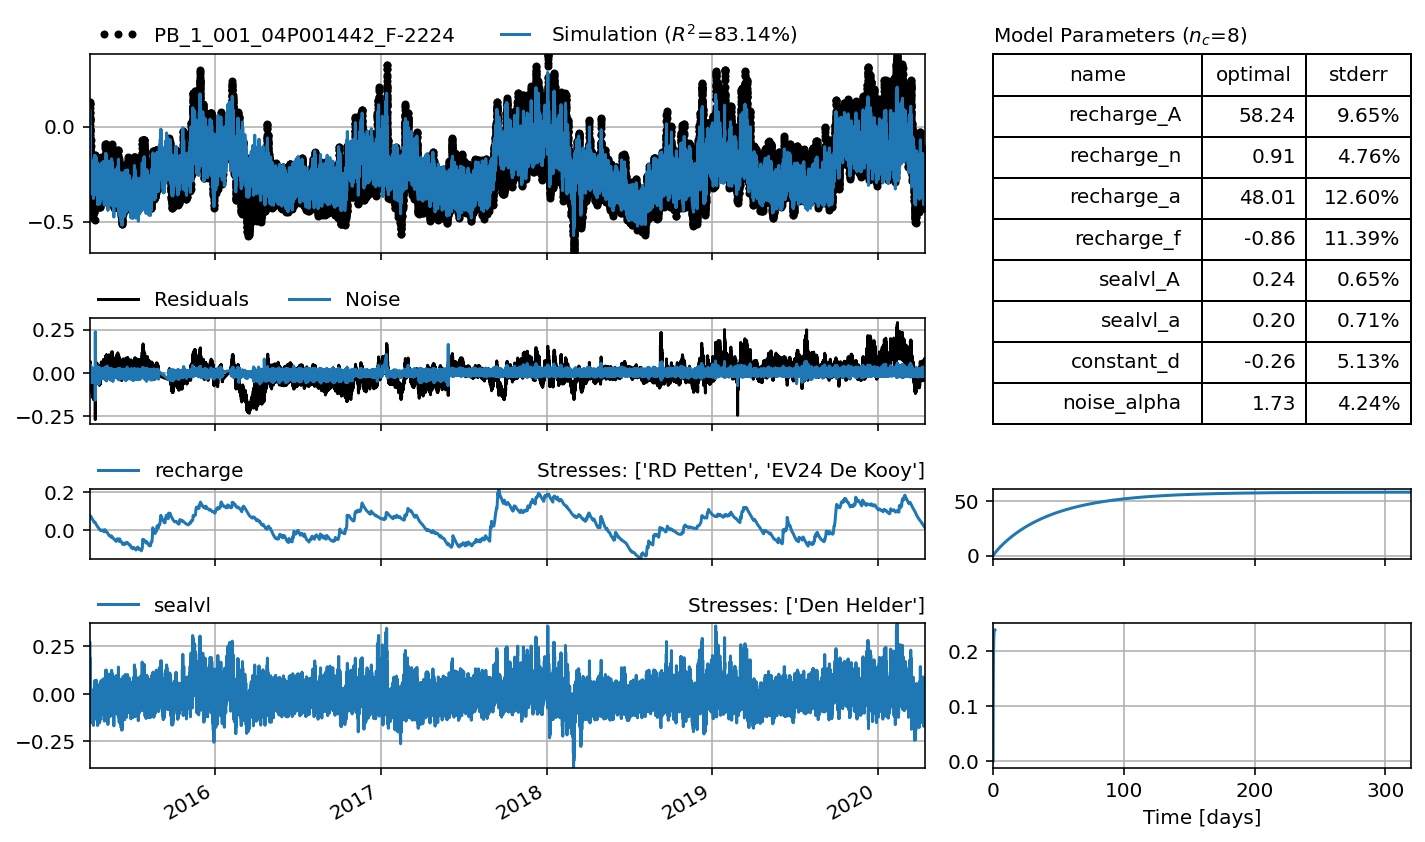

In [8]:
# stuk beter
ml = ps.Model(head, name="hourly")
ml.settings["freq"] = "H"
rm = ps.RechargeModel(prec, evap, name="recharge", rfunc=ps.Gamma)
ml.add_stressmodel(rm)
sm = ps.StressModel(sea - sea.mean(), ps.Exponential, "sealvl",
                    settings="waterlevel")
ml.add_stressmodel(sm)
#ml.solve(noise=False, report=False, tmin="2015-04-01")
ml.solve(noise=True, tmin="2015-04-01", report=False)
ml.plots.results(figsize=(10, 6), adjust_height=True)
plt.tight_layout()

Dit model presteert veel beter, omdat de informatie die in het zeepeil aanwezig is beter gebruikt kan worden om de grondwaterstand te verklaren. 

## Equidistant maken verklarende reeks
Voor de meeste tijdreeksanalyseprogramma's is het nodig dat de verklarende reeksen gelijke tijdstappen hebben, ofwel equidistant zijn. In sommige gevallen worden ze zo aangeleverd. Als dat niet zo is, is het nodig om de reeksen equidistant te maken. De manier waarop dit gebeurt, hangt af van het type verklarende reeks. Rivierpeilen kunnen bijvoorbeeld geïnterpoleerd worden afhankelijk van de grootte van de tijdstap en de dynamiek van de reeks. Bij onttrekkingsreeksen moet men zich afvragen of een missende waarde betekent dat de onttrekking uit stond, of dat er gegevens ontbreken omdat er geen waarneming heeft plaatsgevonden. Het opvullen van de data introduceert onzekerheden, die niet automatisch worden meegenomen in de analyse. Men kan er ook voor kiezen de tijdstap van de tijdreeksanalyse te vergroten, wanneer dat beter bij de resolutie van de beschikbare gegevens past. In onderstaande figuur worden de verschillende type reeksen geïllusteerd: 

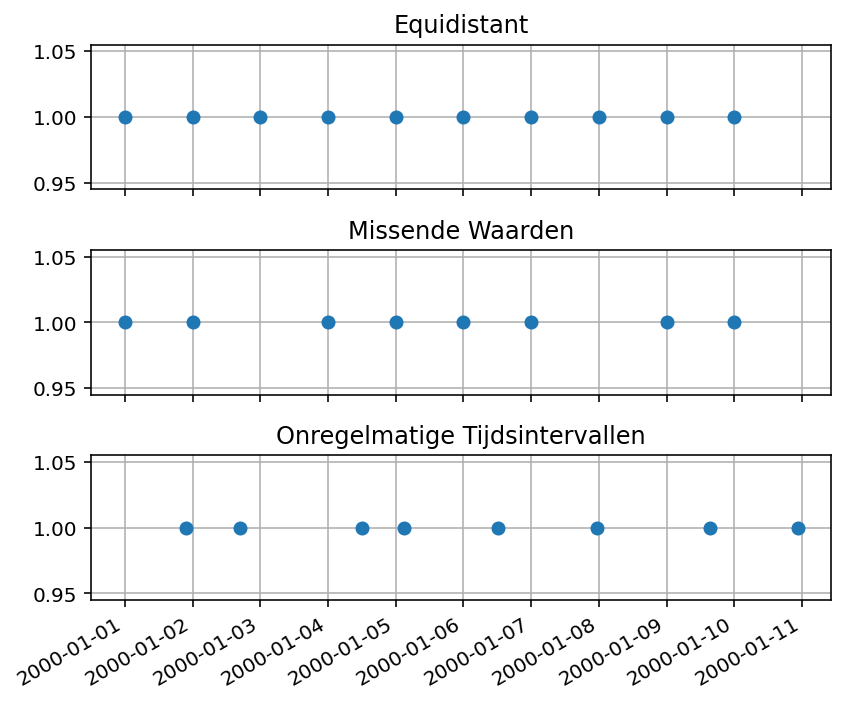

In [9]:

regular = pd.Series(index=pd.date_range("2000-01-01", "2000-01-10", freq="D"),
                    data=np.ones(10))
missing_data = regular.copy()
missing_data.loc[["2000-01-03", "2000-01-08"]] = np.nan

index = [t + pd.Timedelta(np.random.rand()*24, unit="H")
         for t in missing_data.index]
irregular = missing_data.copy()
irregular.index = index

fig, axes = plt.subplots(3, 1, figsize=(6, 5), sharex=True, sharey=True)

regular.plot(ax=axes[0], linestyle=" ", marker="o", x_compat=True)
missing_data.plot(ax=axes[1], linestyle=" ", marker="o", x_compat=True)
irregular.plot(ax=axes[2], linestyle=" ", marker="o", x_compat=True)

for i, name in enumerate(["Equidistant", "Missende Waarden", "Onregelmatige Tijdsintervallen"]):
    axes[i].grid()
    axes[i].set_title(name)
plt.tight_layout()

## Voorgeschiedenis verklarende reeks


Elk hydrologisch systeem heeft een zeker geheugen. Dit betekent dat de de stijghoogte afhangt van wat er een bepaalde periode ervoor is gebeurd. Daarom kent elk model een zekere inloopperiode. Bij het fitten van een grondwaterstand is het belangrijk dat er voldoende informatie over verklarende reeksen aanwezig is vóór de eerste waarneming waarop gekalibreerd wordt. Wanneer dat niet het geval is, zal er een schatting gemaakt moeten worden, óf de betreffende waarnemingen zullen niet in de optimalisatie meegenomen moeten worden. In onderstaand voorbeeld is de neerslag bekend gedurende een periode van 100 dagen vóór de eerste stijghoogtemeting. Daarvóór wordt aangenomen dat de neerslag 0 is. 

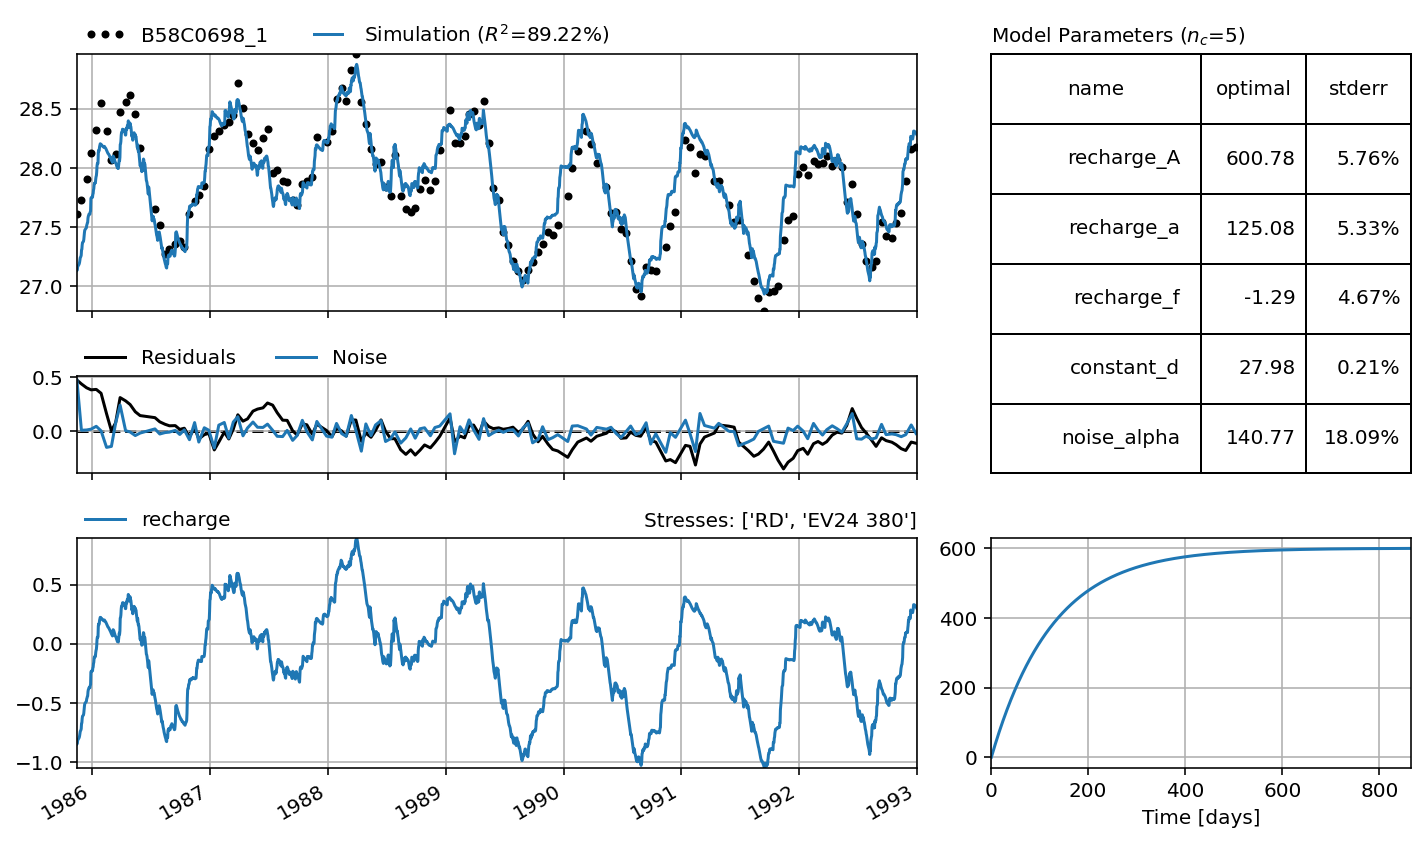

In [10]:
# Voorbeeld van warmup problematiek
obs = ps.read_dino('data/B58C0698001_1.csv')

# lees weerdata
knmi = ps.read.knmi.KnmiStation.fromfile(
    'data/neerslaggeg_HEIBLOEM-L_967-2.txt')
rain = ps.TimeSeries(
    knmi.data['RD'][obs.series.index[0]-np.timedelta64(100, 'D'):], settings='prec')
evap = ps.read_knmi('data/etmgeg_380.txt', variables='EV24')

# also add 9 hours to the evaporation
s = evap.series_original
s.index = s.index + pd.to_timedelta(9, 'h')
evap.series_original = s

# Create the time series model
ml = ps.Model(obs)

settingsprec = ps.timeseries.TimeSeries._predefined_settings['prec']
settingsprec['fill_before'] = 0.00
settingsevap = ps.timeseries.TimeSeries._predefined_settings['evap']

# Create stress
sm = ps.StressModel2(stress=[rain, evap], settings=(settingsprec, settingsevap), rfunc=ps.Exponential,
                     name='recharge')
ml.add_stressmodel(sm)

# Solve
ml.solve(tmax='1993', report=False)
ml.plots.results(figsize=(10, 6));

Het is duidelijk te zien dat simulatie in het begin van de reeks lager ligt dan de metingen. Dit wordt gecompenseerd door een te hoge ligging aan het eind van de reeks. In onderstaand voorbeeld nemen we hetzelfde model, maar nu gaan we uit van de gemiddelde neerslag tijdens de inloopperiode. 

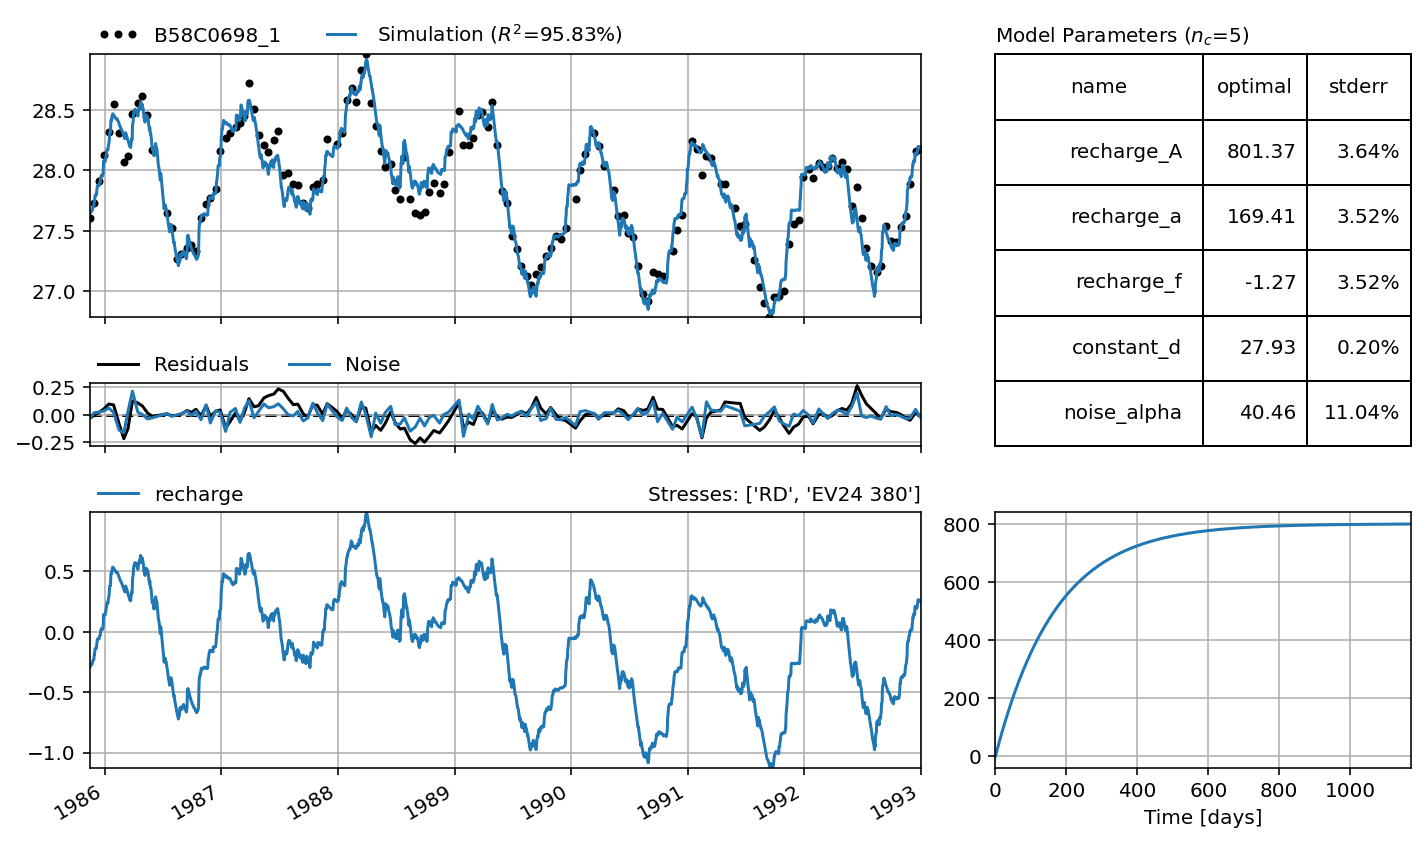

In [11]:
# Create the time series model
ml2 = ps.Model(obs)

settingsprec = ps.timeseries.TimeSeries._predefined_settings['prec']
settingsprec['fill_before'] = 'mean'
settingsevap = ps.timeseries.TimeSeries._predefined_settings['evap']

# Create stress
sm2 = ps.StressModel2(stress=[rain, evap], settings=(settingsprec, settingsevap), rfunc=ps.Exponential,
                      name='recharge')
ml2.add_stressmodel(sm2)

# Solve
ml2.solve(tmax='1993', report=False)
ml2.plots.results(figsize=(10, 6));

Nu het gemiddelde wordt genomen vóór dat er neerslagdata aanwezig is, is er geen trend in de residuen meer aanwezig. De modelfit is ook verbeterd, en de respons van de neerslag ziet er ook significant anders uit. De gevonden responstijd van de neerslag is veel groter dan 100 dagen. Daarom is het van belang neerslag voldoende neerslagggevens te hebben of een realistische schatting, indien deze niet aanwezig zijn.

## Eenheden afstemmen
Voor de interpretatie van de resultaten (en soms ook voor het succes van de kalibratie) is het gewenst om de eenheden van de verschillende reeksen goed te kiezen en eventueel op elkaar af te stemmen.   
In onderstaand voorbeeld proberen we de invloed van een onttrekking vast te stellen. De invoer is aangeleverd op dagbasis in standaardeenheden. Neerslag en verdamping worden geleverd  in meters per dag, en de onttrekking in kubieke meters per dag. We zijn geïnteresseerd in het het totaal-effect van de onttrekking ter hoogte van de waarnemingsput. Eerst doen we een tijdreeksanalyse met de eenheden zoals we die zijn aangeleverd: 

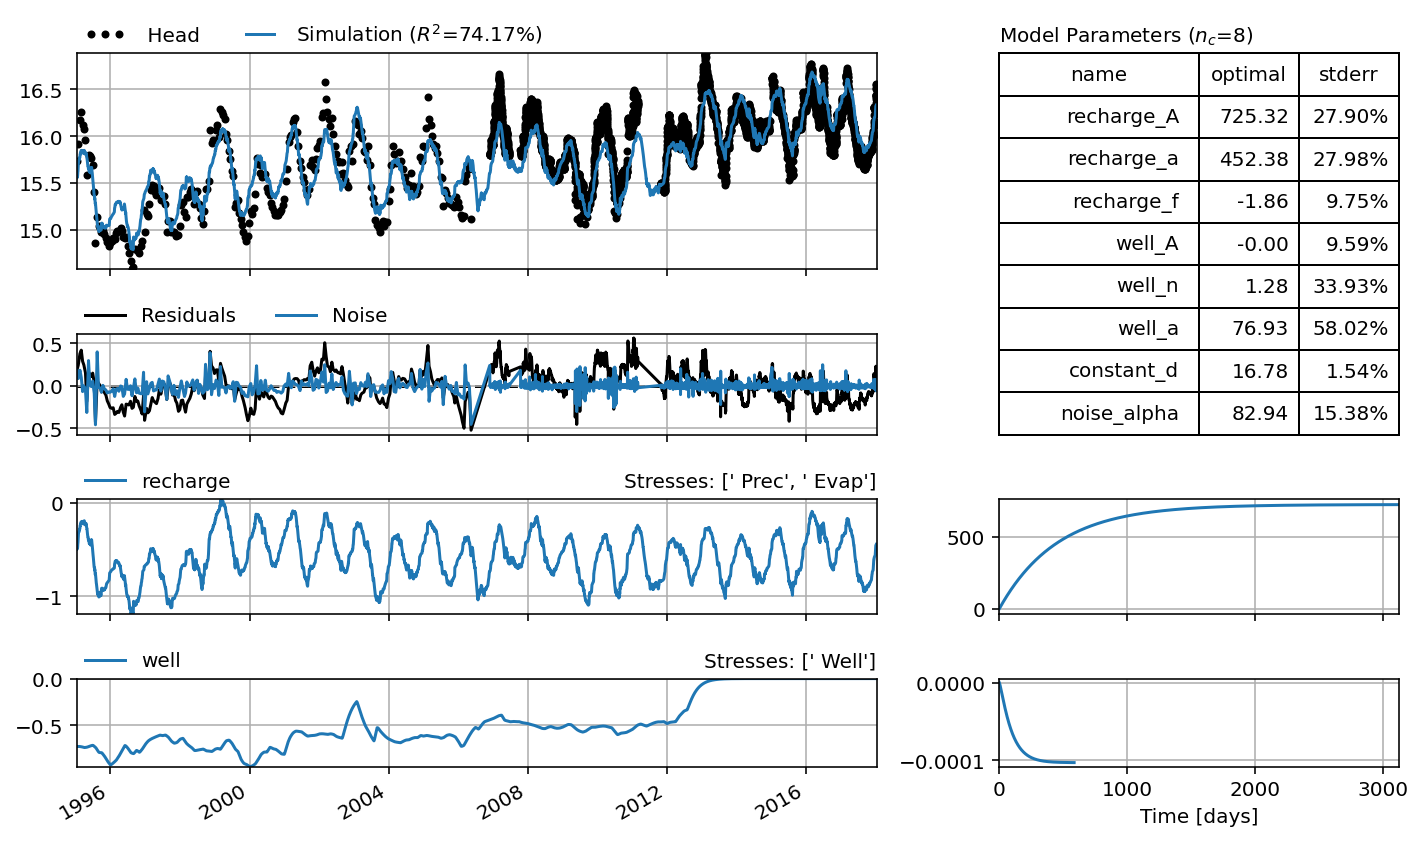

In [12]:
# Voorbeeld met verschillende eenheden, waardoor de gain niet te interpreteren is.
head = pd.read_csv("data/head_wellex.csv", index_col="Date",
                   parse_dates=True, squeeze=True)
rain = pd.read_csv("data/prec_wellex.csv", index_col="Date",
                   parse_dates=True)  # dagwaarden m/d
evap = pd.read_csv("data/evap_wellex.csv", index_col="Date",
                   parse_dates=True)  # dagwaarden m/d
well = pd.read_csv("data/well_wellex.csv", index_col="Date",
                   parse_dates=True)  # dagwaarden m3/d
ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
sm = ps.StressModel(well, rfunc=ps.Gamma, name="well",
                    settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant='True')
ml.plots.results(figsize=(10, 6), adjust_height=True);

Het effect van de put (de "gain") is gelijk aan de parameter well_A in de tabel. Deze heeft de eenheid van stijghoogte gedeeld door de eenheid van de onttrekking. In dit geval is dat dus een verlaging (in meter) bij een onttrekking van één kubieke meter per dag. Vanzelfsprekend is dat een heel klein getal, en in de tabel wordt dit zelfs afgerond naar 0.00. De gain van de recharge stelt de stijghoogte-verhoging voor die zou ontstaan als het continu één meter per dag zou regenen (737 meter). Evenzo is de verlaging door één meter verdamping per dag gelijk aan 1.86*737 = 1370 meter. Deze eenheden zijn niet erg praktsch voor de interpretatie. Daarom doen we deze tijdreeksanalyse nog eens opnieuw, maar dan veranderen we de eenheden van verdamping en neerslag naar mm/dag, en de onttrekking in miljoen kubieke meters per jaar.  
  

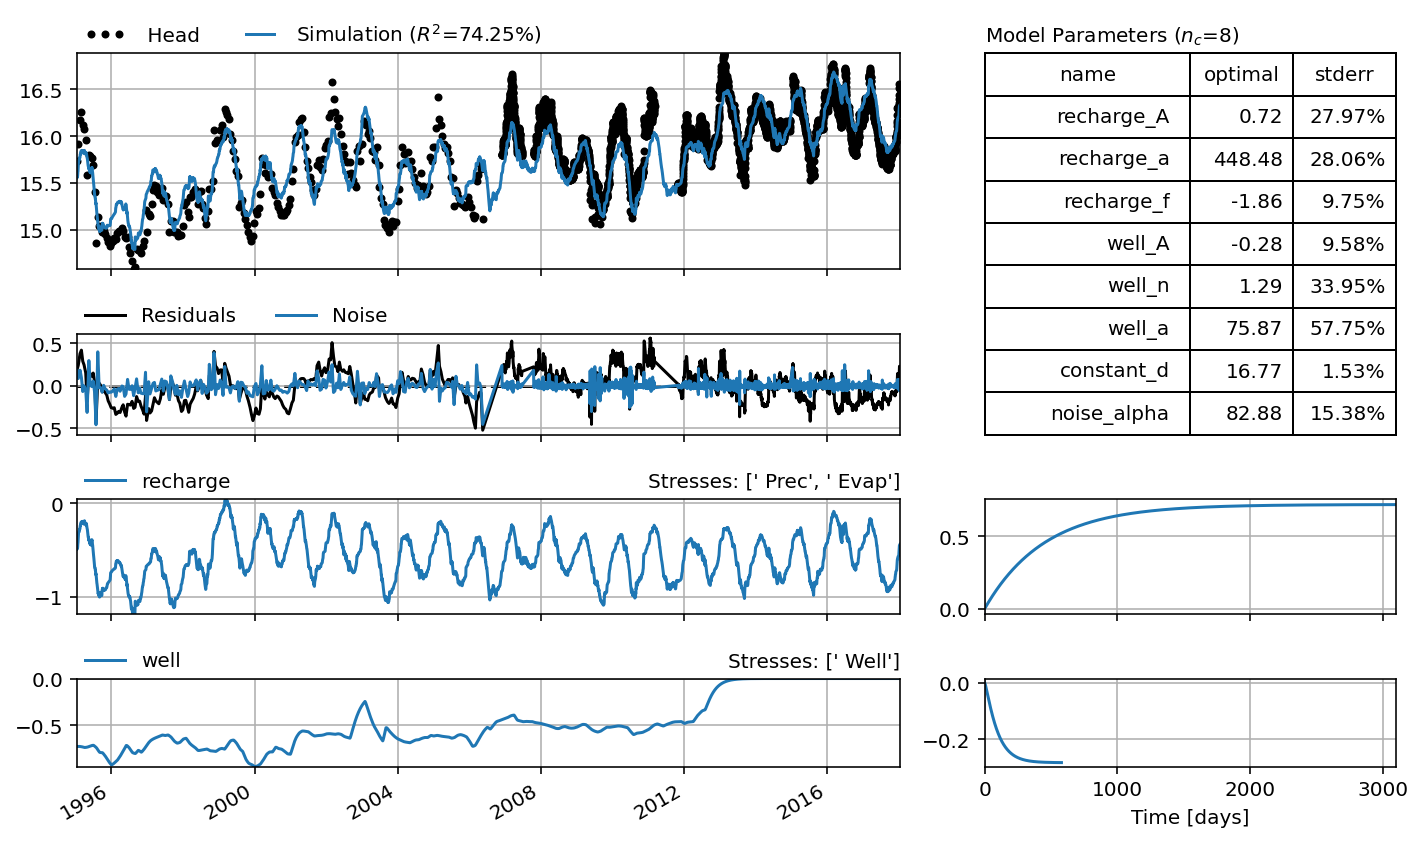

In [13]:
# Verandering naar een goed voorbeeld waar dat wel kan.
head = pd.read_csv("data/head_wellex.csv", index_col="Date",
                   parse_dates=True, squeeze=True)
rain = pd.read_csv("data/prec_wellex.csv",
                   index_col="Date", parse_dates=True) * 1e3
evap = pd.read_csv("data/evap_wellex.csv",
                   index_col="Date", parse_dates=True) * 1e3
well = pd.read_csv("data/well_wellex.csv", index_col="Date",
                   parse_dates=True) * 365.25 / 1e6

ml = ps.Model(head)
sm = ps.RechargeModel(rain, evap, name="recharge",
                      rfunc=ps.Exponential, recharge=ps.rch.Linear())
ml.add_stressmodel(sm)
sm = ps.StressModel(well, rfunc=ps.Gamma, name="well",
                    settings="well", up=False)
ml.add_stressmodel(sm)
ml.solve(noise=True, initial=False, report=False, fit_constant='True')
ml.plots.results(figsize=(10, 6), adjust_height=True);

Bovenstaande figuur toont de resultaten met de gewijzigde eenheden. Wat opvalt is dat ook na omrekening de getallen iets verschillen. Dit zijn afwijkingen die ontstaan bij de optimalisatie van de parameters, die nu iets anders verloopt omdat de verhoudingen tussen de invoerreeksen verschillen. De gain bij één millimeter neerslag per dag  is nu 0.72 meter. De verlaging ten gevolge van een onttrekking van één miljoen kuub per jaar is 0.28 meter. Om de eindverhoging bij stopzetting van de winning te schatten moet deze waarde vermenigvuldigd worden met de werkelijke wincapaciteit. (in miljoen kuub per jaar). Wanneer het een winning van 2 miljoen kuub per jaar betreft, schatten we de verhoging op 56 centimeter.       